In [5]:
# !pip install numpy


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
!which python

/home/murali/anaconda3/envs/myenv/bin/python


In [65]:
print(cv2.__version__)

4.10.0


In [2]:
# !conda info --envs

# conda environments:
#
base                  *  /Users/sreekanthgopi/miniconda3
                         /Users/sreekanthgopi/opt/anaconda3/envs/AutoGPT
                         /Users/sreekanthgopi/opt/anaconda3/envs/AutoGPT2
                         /Users/sreekanthgopi/opt/anaconda3/envs/FaceNet
                         /Users/sreekanthgopi/opt/anaconda3/envs/MMMMusic
                         /Users/sreekanthgopi/opt/anaconda3/envs/TopicGeneration
                         /Users/sreekanthgopi/opt/anaconda3/envs/audiocraft
                         /Users/sreekanthgopi/opt/anaconda3/envs/magenta
                         /Users/sreekanthgopi/opt/anaconda3/envs/muse_env



In [6]:
# !pip show numpy

In [7]:
# !pip install opencv-python


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [12]:
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.decomposition import FastICA

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [64]:
# pip install mediapipe

Read 1000 frames.
1000 frames saved to file.


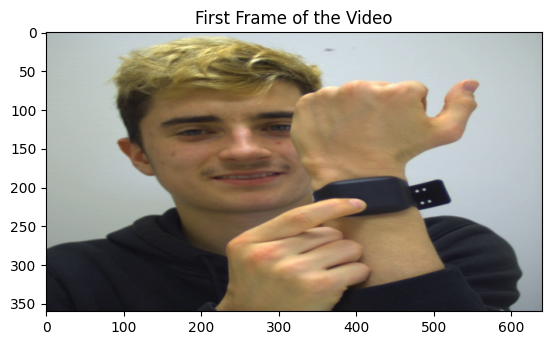

In [1]:
import cv2
import pickle
import os
import matplotlib.pyplot as plt

def read_video_frames(video_file, max_frames=1000):
    cap = cv2.VideoCapture(video_file)
    frames = []
    count = 0
    while count < max_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Stop if no frame is retrieved
        frames.append(frame)
        count += 1
    cap.release()
    print(f"Read {count} frames.")
    return frames

def display_first_frame(frames):
    if frames is not None and len(frames) > 0:
        frame_rgb = cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.title("First Frame of the Video")
        plt.show()
    else:
        print("No frame to display.")

def load_or_read_video_frames(video_path, frames_filename='saved_framess2t1.pkl', max_frames=1000):
    # Check if frames are already saved to a file
    if os.path.isfile(frames_filename):
        # If frames are saved, load them from the file
        with open(frames_filename, 'rb') as file:
            frames = pickle.load(file)
        print("Frames loaded from file.")
    else:
        # If frames are not saved, read and store video frames
        frames = read_video_frames(video_path, max_frames)
        # Save the frames to a file for future use
        with open(frames_filename, 'wb') as file:
            pickle.dump(frames, file)
        print(f"{len(frames)} frames saved to file.")
    return frames

video_path = 'compressed_video.mp4'
frames_filename = 'saved_framess2t1.pkl'

frames = load_or_read_video_frames(video_path, frames_filename, max_frames=1000)
display_first_frame(frames)


In [2]:
len(frames)

1000

### Processed Frame with Face Mesh and Highlighted ROIs

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1718033408.300767  118983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718033408.311083  118983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/murali/anaconda3/envs/myenv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


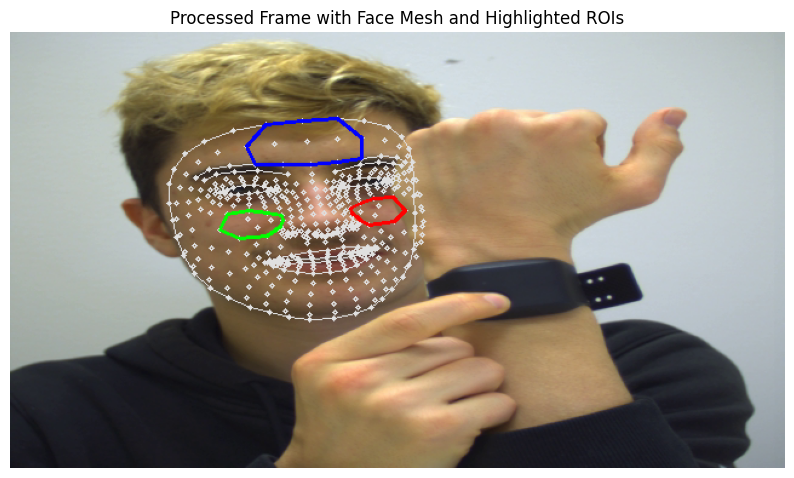

In [3]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe FaceMesh
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

# Specify the drawing specifications for visualization
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
def process_frames_and_extract_roi_values(frames):
    processed_frames = []
    roi_signals = {'forehead': [], 'left_cheek': [], 'right_cheek': []}

    with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
        for frame in frames:
            frame_copy = frame.copy()
            image_rgb = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB)
            results_mesh = face_mesh.process(image_rgb)

            if results_mesh.multi_face_landmarks:
                for face_landmarks in results_mesh.multi_face_landmarks:
                    # Drawing the facial landmarks for visualization
                    mp_drawing.draw_landmarks(frame_copy, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS, landmark_drawing_spec=drawing_spec, connection_drawing_spec=drawing_spec)

                    # For each ROI, calculate, store the mean pixel values, and draw the ROI
                    for name, indices in [('forehead', [107, 66, 69, 109, 10, 338, 299, 296, 336, 9]), 
                                          ('left_cheek', [118, 119, 100, 126, 209, 49, 129, 203, 205, 50]), 
                                          ('right_cheek', [347, 348, 329, 355, 429, 279, 358, 423, 425, 280])]:
                        # Extracting ROI pixels
                        roi_pixels = np.array([frame[int(face_landmarks.landmark[idx].y * frame.shape[0]), int(face_landmarks.landmark[idx].x * frame.shape[1])] for idx in indices])
                        mean_pixel_value = np.mean(roi_pixels, axis=0)
                        roi_signals[name].append(mean_pixel_value)

                        # Drawing ROI
                        points = np.array([[int(face_landmarks.landmark[idx].x * frame_copy.shape[1]), int(face_landmarks.landmark[idx].y * frame_copy.shape[0])] for idx in indices])
                        cv2.polylines(frame_copy, [np.array(points)], True, (255, 0, 0) if name == 'forehead' else (0, 255, 0) if name == 'left_cheek' else (0, 0, 255), 2)

            processed_frames.append(frame_copy)

    return processed_frames, roi_signals


processed_frames, roi_signals = process_frames_and_extract_roi_values(frames)

# Display one of the processed frames with ROIs
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(processed_frames[0], cv2.COLOR_BGR2RGB))
plt.title('Processed Frame with Face Mesh and Highlighted ROIs')
plt.axis('off')
plt.show()


In [4]:
print(f"Total frames read: {len(frames)}")

Total frames read: 1000


In [5]:
import pandas as pd

# Create DataFrame from roi_signals
roi_df = pd.DataFrame.from_dict(roi_signals)

# Save DataFrame to CSV
roi_df.to_csv('roi_signals.csv', index=False)


In [120]:
# (processed_frames[0])

In [122]:
# import numpy as np
# import pandas as pd

# # Assuming processed_frames is a list of arrays
# # Flatten each array and concatenate them along the appropriate axis
# flattened_data = np.concatenate([arr.flatten().reshape(1, -1) for arr in processed_frames])

# # Convert the flattened data to a DataFrame
# processed_frames_df = pd.DataFrame(flattened_data)

# # Save DataFrame to CSV
# processed_frames_df.to_csv('processed_frames.csv', index=False)


In [6]:
len(roi_signals.keys())

3

In [7]:
print(f"Number of ROIs: {len(roi_signals.keys())}")
for roi, values in roi_signals.items():
    print(f"{roi}: {values[:5]}")  # Print first 5 values for each ROI


Number of ROIs: 3
forehead: [array([ 60.8,  97.1, 123.8]), array([ 57.5,  91.2, 116.2]), array([ 58.7,  92.6, 118.7]), array([ 60.9,  97.3, 124. ]), array([ 59.9,  96.5, 122.6])]
left_cheek: [array([ 76.1, 107.1, 148.4]), array([ 74.1, 106.9, 147.5]), array([ 73.9, 107. , 148.8]), array([ 74.4, 106.9, 148.9]), array([ 74.2, 105.3, 147.9])]
right_cheek: [array([ 82.3, 112.8, 150.3]), array([ 74.2, 103.4, 140.6]), array([ 76.5, 104.4, 141.6]), array([ 77.5, 108.8, 145.7]), array([ 78.7, 108.5, 145.1])]


In [8]:
print(f"Number of ROIs: {len(roi_signals.keys())}")
for roi, values in roi_signals.items():
    print(f"{roi}: {values[:5]}")  # Print first 5 values for each ROI
    print(f"Type of values in {roi}: {type(values[0])}")  # Check type of values for each ROI
    print(f"Type of values in {roi}: {values[0].dtype}")  # Check datatype of values for each ROI

Number of ROIs: 3
forehead: [array([ 60.8,  97.1, 123.8]), array([ 57.5,  91.2, 116.2]), array([ 58.7,  92.6, 118.7]), array([ 60.9,  97.3, 124. ]), array([ 59.9,  96.5, 122.6])]
Type of values in forehead: <class 'numpy.ndarray'>
Type of values in forehead: float64
left_cheek: [array([ 76.1, 107.1, 148.4]), array([ 74.1, 106.9, 147.5]), array([ 73.9, 107. , 148.8]), array([ 74.4, 106.9, 148.9]), array([ 74.2, 105.3, 147.9])]
Type of values in left_cheek: <class 'numpy.ndarray'>
Type of values in left_cheek: float64
right_cheek: [array([ 82.3, 112.8, 150.3]), array([ 74.2, 103.4, 140.6]), array([ 76.5, 104.4, 141.6]), array([ 77.5, 108.8, 145.7]), array([ 78.7, 108.5, 145.1])]
Type of values in right_cheek: <class 'numpy.ndarray'>
Type of values in right_cheek: float64


In [9]:
print(f"Type of values in {roi}: {values[0].dtype}")  # Check datatype of values for each ROI

Type of values in right_cheek: float64


In [10]:
if len(frames) > 0:
    print(f"First frame shape: {frames[0].shape}, dtype: {frames[0].dtype}")
else:
    print("No frames to display.")

First frame shape: (360, 640, 3), dtype: uint8


In [14]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    if len(data) < 3 * order:
        print("Data too short for this order, considering padding or lowering order.")
        order = min(order, len(data) // 3)
    b, a = butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
    y = filtfilt(b, a, data, axis=0)
    return y

fs = 35  
lowcut = 0.65
highcut = 4.0


# Convert lists of pixel values into numpy arrays
for roi, signals_list in roi_signals.items():
    roi_signals[roi] = np.array(signals_list)

filtered_signals = {}

for roi, signals in roi_signals.items():
    if signals.shape[0] > 1:
        filtered_signal = np.zeros_like(signals)
        for i in range(signals.shape[1]):  # Filtering channel-wise
            filtered_signal[:, i] = butter_bandpass_filter(signals[:, i], lowcut, highcut, fs, order=6)
        filtered_signals[roi] = filtered_signal
    else:
        print(f"Not enough data for filtering {roi}, skipping.")
        filtered_signals[roi] = signals

# Print the filtered_signals dictionary
print("Filtered Signals:")
for roi, signals in filtered_signals.items():
    print(f"ROI: {roi}, Filtered Signals Shape: {signals.shape}")

Filtered Signals:
ROI: forehead, Filtered Signals Shape: (989, 3)
ROI: left_cheek, Filtered Signals Shape: (989, 3)
ROI: right_cheek, Filtered Signals Shape: (989, 3)


W0000 00:00:1718033613.958881  119999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718033613.976372  119999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


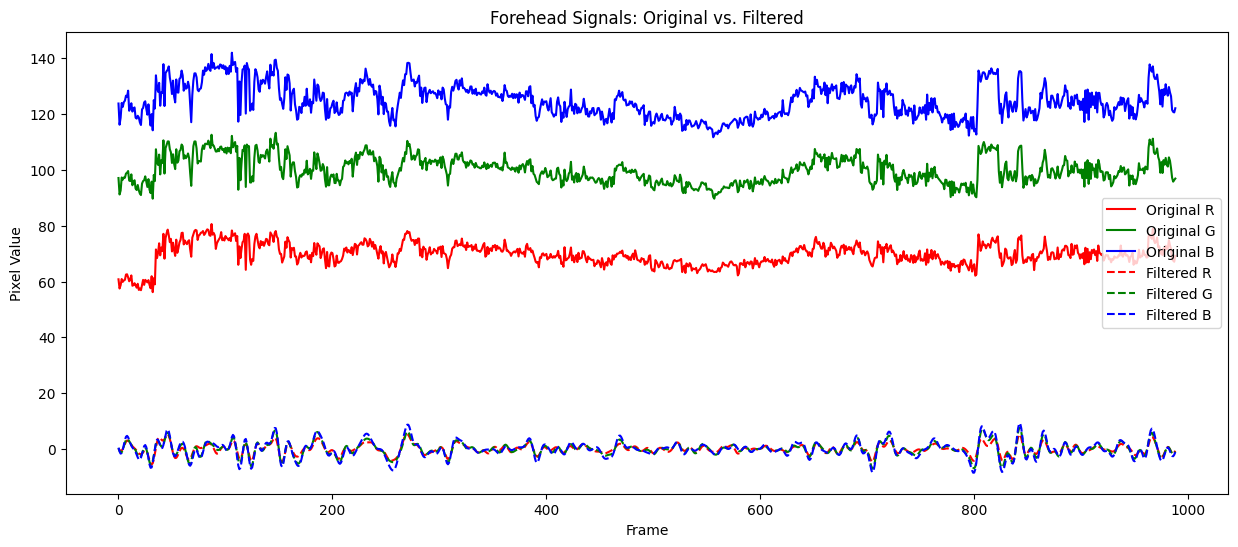

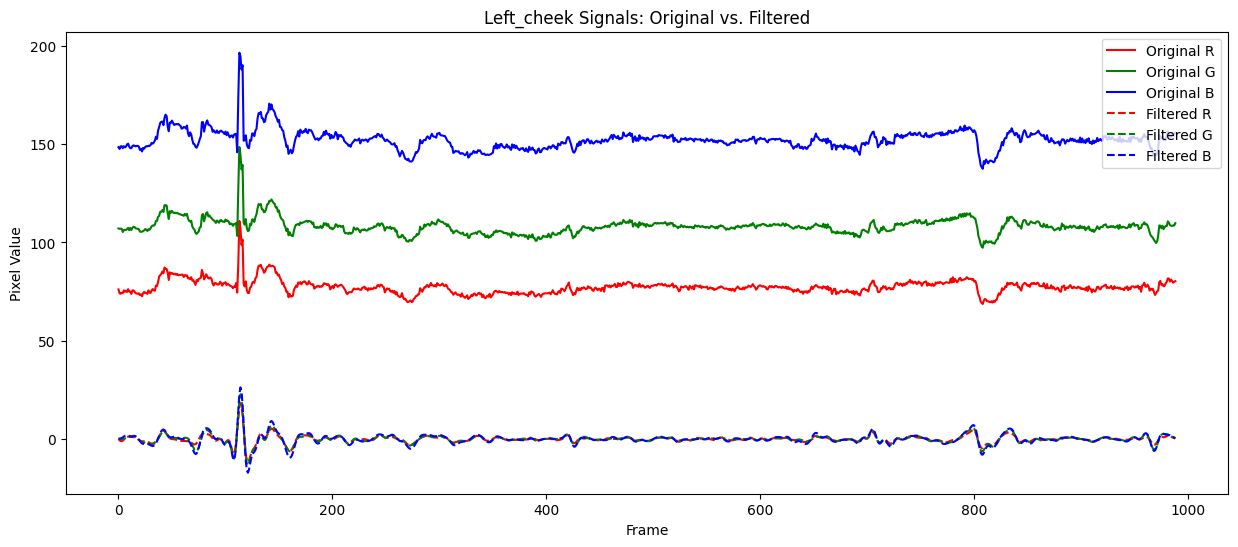

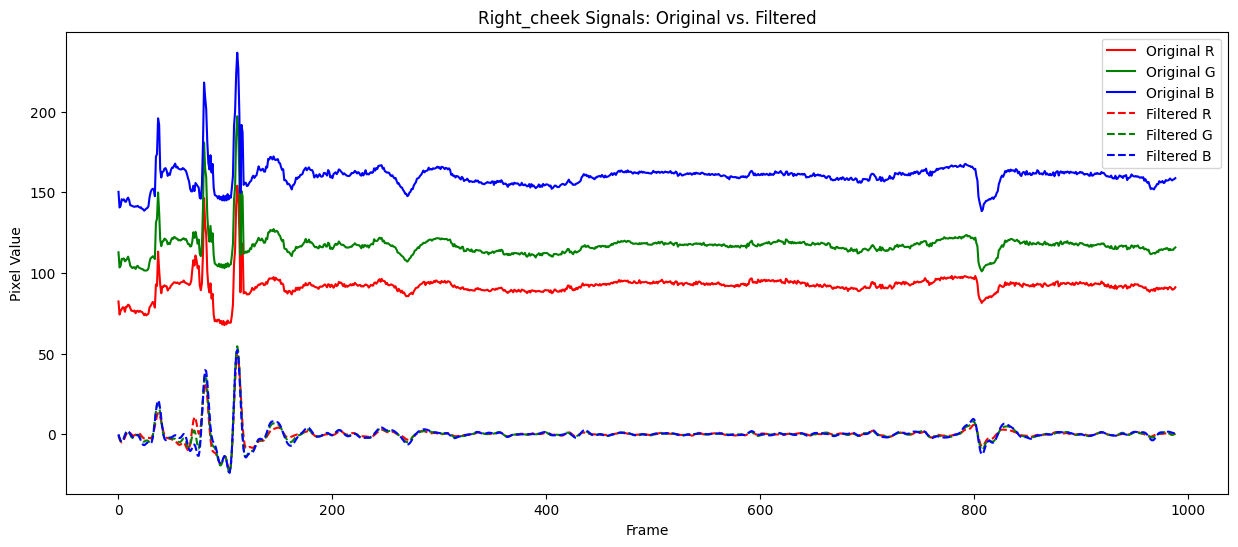

In [15]:
import matplotlib.pyplot as plt

def plot_signals(original_signals, filtered_signals, title):
    plt.figure(figsize=(15, 6))
    
    # Plotting the original signals
    plt.plot(original_signals[:, 0], 'r', label='Original R')
    plt.plot(original_signals[:, 1], 'g', label='Original G')
    plt.plot(original_signals[:, 2], 'b', label='Original B')
    
    # Plotting the filtered signals
    plt.plot(filtered_signals[:, 0], 'r--', label='Filtered R')
    plt.plot(filtered_signals[:, 1], 'g--', label='Filtered G')
    plt.plot(filtered_signals[:, 2], 'b--', label='Filtered B')
    
    plt.title(title)
    plt.xlabel('Frame')
    plt.ylabel('Pixel Value')
    plt.legend()
    plt.show()

processed_frames, roi_signals = process_frames_and_extract_roi_values(frames)

# Convert lists of pixel values into numpy arrays
for roi, signals_list in roi_signals.items():
    roi_signals[roi] = np.array(signals_list)

# Plot the signals before and after filtering for each ROI
for roi, original_signals in roi_signals.items():
    filtered_signals_roi = filtered_signals.get(roi)
    if filtered_signals_roi is not None:
        plot_signals(original_signals, filtered_signals_roi, f'{roi.capitalize()} Signals: Original vs. Filtered')
    else:
        print(f"No filtered signals available for {roi}. Skipping plotting.")


In [16]:
# Example diagnostic print for signals
for roi, signals in filtered_signals.items():
    print(f"{roi}: G Sample: {signals[:, 1][:5]}, R Sample: {signals[:, 0][:5]}, B Sample: {signals[:, 2][:5]}")

forehead: G Sample: [ 0.32398545 -0.71559707 -1.30983007 -1.18796845 -0.35509171], R Sample: [ 0.1191745  -0.43030661 -0.71551469 -0.5687852   0.02125657], B Sample: [ 0.46542219 -0.91294762 -1.67760163 -1.46092014 -0.28495741]
left_cheek: G Sample: [ 0.19010558  0.06483558 -0.0200293  -0.03528969  0.02762877], R Sample: [ 0.05374709 -0.56860022 -0.98457791 -1.06400532 -0.79586447], B Sample: [0.25583711 0.26967524 0.36013804 0.57407159 0.90563866]
right_cheek: G Sample: [-0.44001978 -2.67164237 -4.23126176 -4.68105384 -3.95635135], R Sample: [-1.00281334 -3.00862077 -4.49750055 -5.11607499 -4.76409082], B Sample: [-0.11365343 -2.43941797 -4.11272991 -4.69878789 -4.11567233]


In [17]:
import random

# Print random values from filtered_signals
for roi, signals in filtered_signals.items():
    if signals.shape[0] > 1:
        random_index = random.randint(0, signals.shape[0] - 1)
        random_value = signals[random_index]
        print(f"ROI: {roi}, Random Value at Index {random_index}: {random_value}")
    else:
        print(f"No data for {roi}, skipping.")


ROI: forehead, Random Value at Index 242: [-0.28337354 -0.1969329   0.10164107]
ROI: left_cheek, Random Value at Index 370: [-0.43419463 -0.19957305  0.02160559]
ROI: right_cheek, Random Value at Index 922: [0.4726528  0.6029922  0.65871368]


In [18]:
type(filtered_signals)

dict

In [19]:
import pandas as pd

# Flatten the nested lists in filtered_signals dictionary
flattened_signals = {roi + '_' + channel: [signal[i] for signal in signals for i in range(len(signal))] for roi, signals in filtered_signals.items() for channel in ['R', 'G', 'B']}

# Create DataFrame from flattened dictionary
filtered_df = pd.DataFrame.from_dict(flattened_signals)

# Save DataFrame to CSV file
filtered_csv_path = 'filtered_signals.csv'
filtered_df.to_csv(filtered_csv_path, index=False)

print(f"Filtered signals saved to {filtered_csv_path}")


Filtered signals saved to filtered_signals.csv


In [21]:
def plot_signals2(original_signals, filtered_signals, title):
    plt.figure(figsize=(15, 6))
    
    # Plotting the original signals
    plt.plot(original_signals[:, 0], 'r', label='Filtered R')
    
    # Plotting the filtered signals with an offset in the y-axis
    plt.plot(filtered_signals[:, 0] , 'r--', label='Detrended R (Offset)')
    
    plt.title(title)
    plt.xlabel('Frame')
    plt.ylabel('Pixel Value')
    plt.legend()
    plt.show()


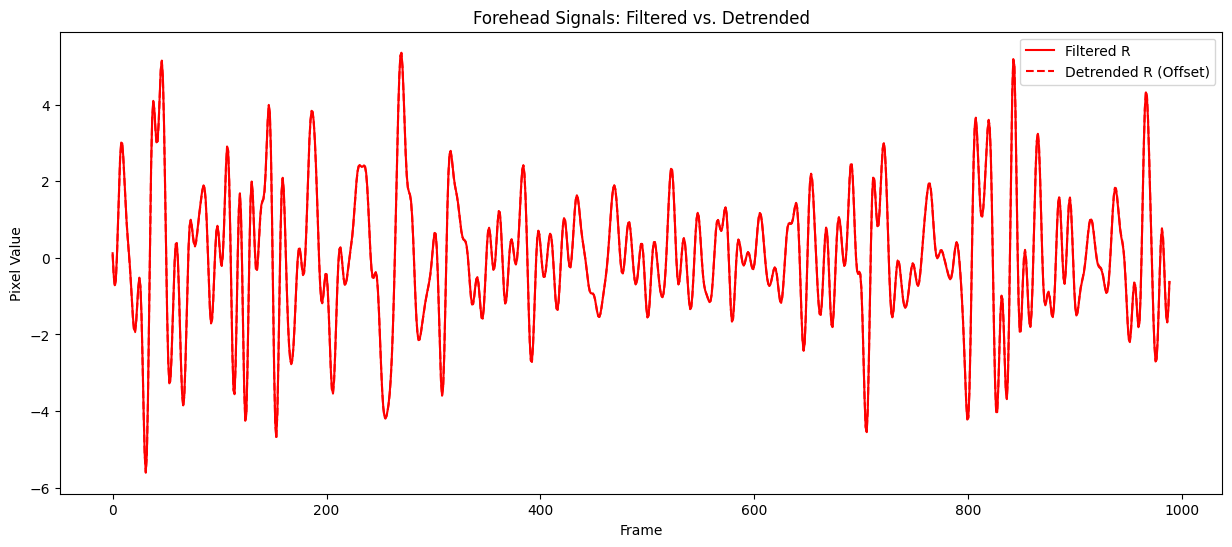

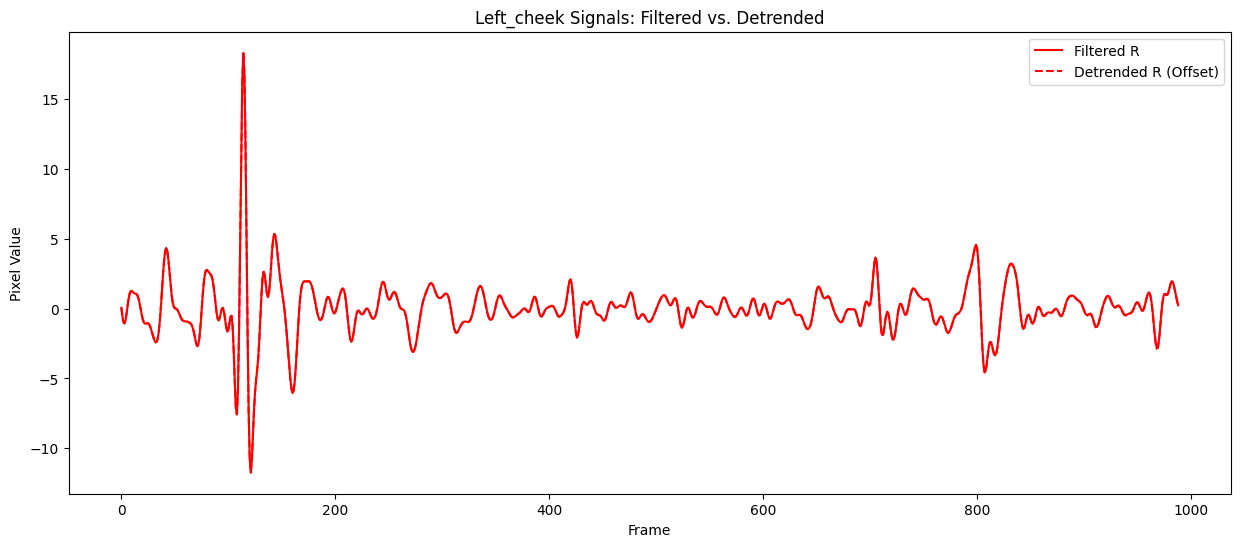

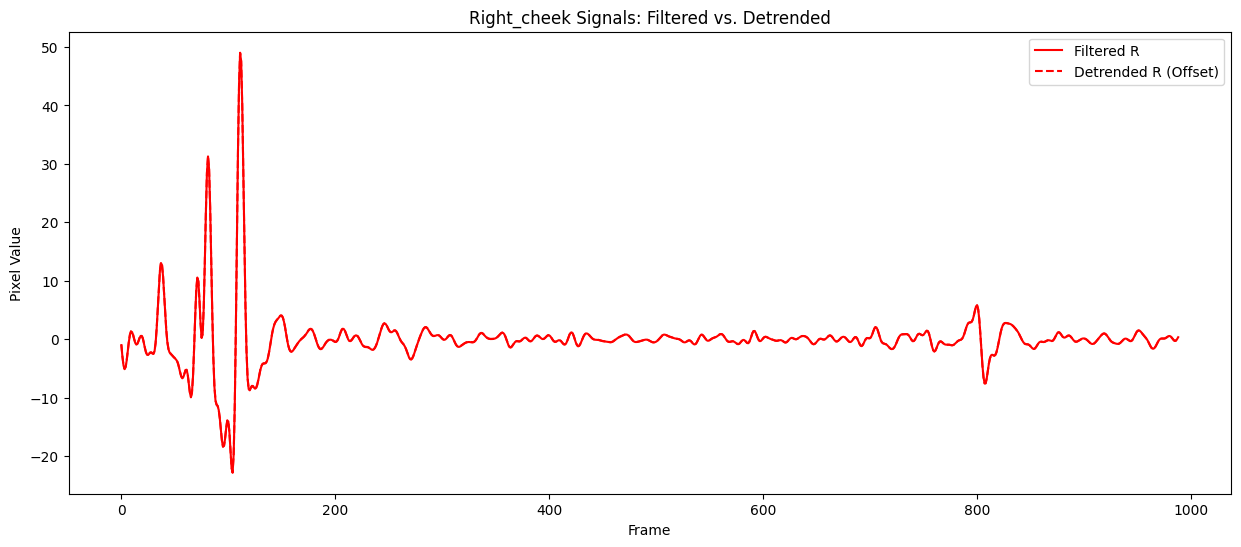

In [22]:
from scipy.signal import detrend

# Function to detrend the signals for each ROI
def detrend_roi_signals(filtered_signals):
    detrended_signals = {}
    for roi, signals in filtered_signals.items():
        detrended_signals[roi] = detrend(signals, axis=0)
    return detrended_signals

# Detrend the filtered signals for each ROI
detrended_signals = detrend_roi_signals(filtered_signals)

# Plot the detrended signals for each ROI
for roi, detrended_signal in detrended_signals.items():
    plot_signals2(filtered_signals[roi], detrended_signal, f'{roi.capitalize()} Signals: Filtered vs. Detrended')


In [23]:
type(detrended_signals)

dict

In [24]:
for roi, signals in detrended_signals.items():
    print(f"{roi}: {signals[:5]}")  # Print first 5 detrended values for each ROI


forehead: [[ 0.08881972  0.30258586  0.43390323]
 [-0.46059821 -0.73694698 -0.9443873 ]
 [-0.74574312 -1.33113031 -1.70896203]
 [-0.59895046 -1.20921903 -1.49220125]
 [-0.00884551 -0.37629261 -0.31615925]]
left_cheek: [[ 0.07333304  0.20183503  0.250154  ]
 [-0.54907149  0.07651434  0.26396392]
 [-0.9651064  -0.00840124  0.35439851]
 [-1.04459103 -0.02371232  0.56830385]
 [-0.7765074   0.03915545  0.89984272]]
right_cheek: [[-9.36616669e-01 -3.50982239e-01 -1.71693149e-03]
 [-2.94252270e+00 -2.58274215e+00 -2.32766876e+00]
 [-4.43150108e+00 -4.14249885e+00 -4.00116800e+00]
 [-5.05017412e+00 -4.59242826e+00 -4.58741327e+00]
 [-4.69828854e+00 -3.86786309e+00 -4.00448500e+00]]


### Detrend the signals for each ROI

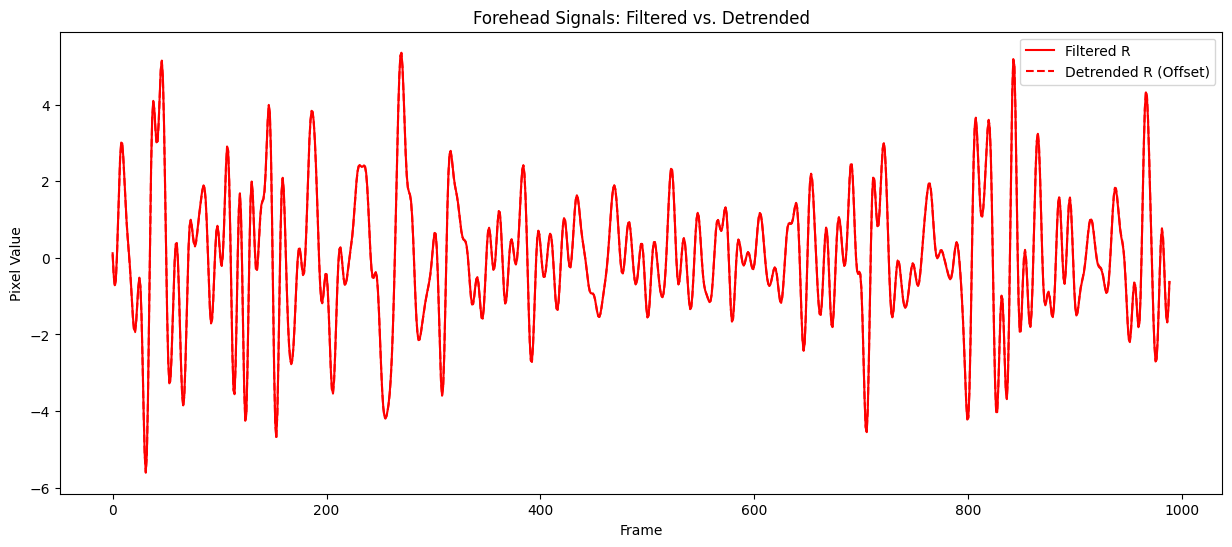

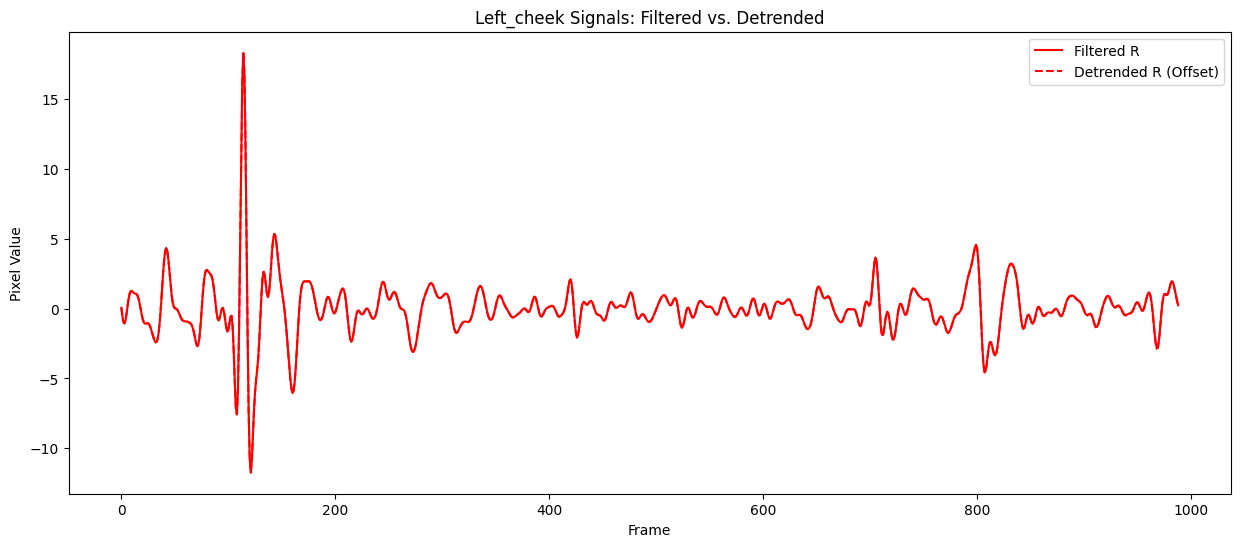

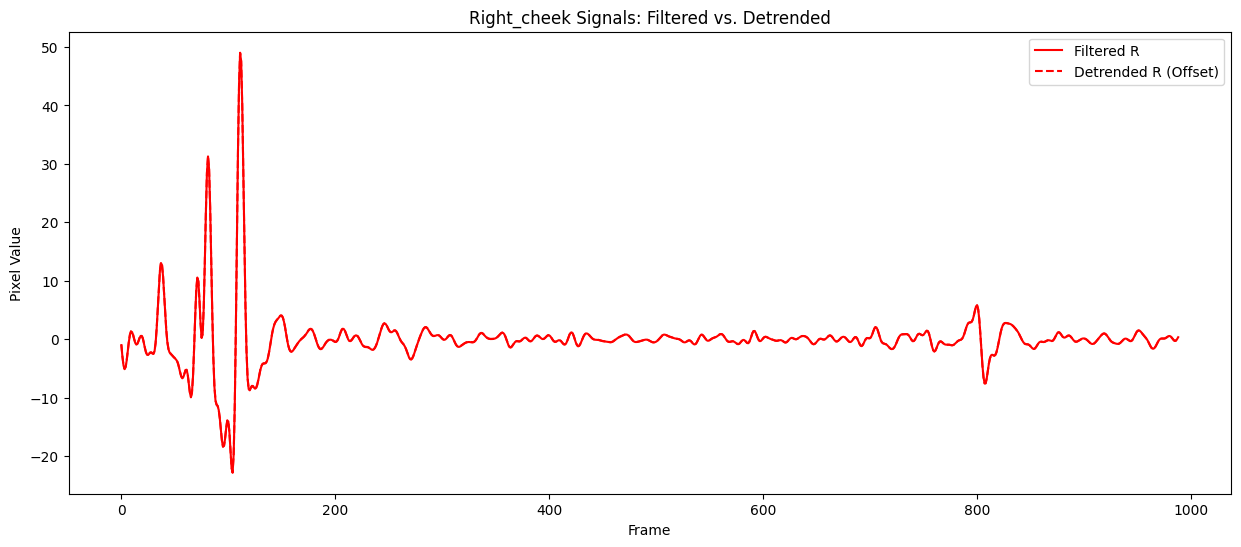

In [25]:
from scipy.signal import detrend

# Function to detrend the signals for each ROI
def detrend_roi_signals(filtered_signals):
    detrended_signals = {}
    for roi, signals in filtered_signals.items():
        detrended_signals[roi] = detrend(signals, axis=0)
    return detrended_signals

# Detrend the filtered signals for each ROI
detrended_signals = detrend_roi_signals(filtered_signals)

# Plot the detrended signals for each ROI
for roi, detrended_signal in detrended_signals.items():
    plot_signals2(filtered_signals[roi], detrended_signal, f'{roi.capitalize()} Signals: Filtered vs. Detrended')


### Processed Frame with Face Mesh and Highlighted ROIs

In [26]:
for roi, signals in filtered_signals.items():
    print(f"{roi}, filtered sample: {signals[:5]}")  # Print first 5 filtered values for each ROI

forehead, filtered sample: [[ 0.1191745   0.32398545  0.46542219]
 [-0.43030661 -0.71559707 -0.91294762]
 [-0.71551469 -1.30983007 -1.67760163]
 [-0.5687852  -1.18796845 -1.46092014]
 [ 0.02125657 -0.35509171 -0.28495741]]
left_cheek, filtered sample: [[ 0.05374709  0.19010558  0.25583711]
 [-0.56860022  0.06483558  0.26967524]
 [-0.98457791 -0.0200293   0.36013804]
 [-1.06400532 -0.03528969  0.57407159]
 [-0.79586447  0.02762877  0.90563866]]
right_cheek, filtered sample: [[-1.00281334 -0.44001978 -0.11365343]
 [-3.00862077 -2.67164237 -2.43941797]
 [-4.49750055 -4.23126176 -4.11272991]
 [-5.11607499 -4.68105384 -4.69878789]
 [-4.76409082 -3.95635135 -4.11567233]]


### Plot original vs. filtered signals for a specific ROI

### GRGB Calculation

In [27]:
flattened_detrend_signals = {roi + '_' + channel: [signal[i] for signal in signals for i in range(len(signal))] for roi, signals in detrended_signals.items() for channel in ['R', 'G', 'B']}

In [28]:
detrended_df = pd.DataFrame.from_dict(flattened_detrend_signals)

In [156]:
# import numpy as np

# def calculate_color_channel_ratios(detrended_df):
#     ratios = {}
#     for column_prefix in ['forehead', 'left_cheek', 'right_cheek']:
#         R = detrended_df[f'{column_prefix}_R'].values
#         G = detrended_df[f'{column_prefix}_G'].values
#         B = detrended_df[f'{column_prefix}_B'].values
#         GR_ratio = G / (R + 1e-6)  # Adding epsilon to avoid division by zero
#         GB_ratio = G / (B + 1e-6)
#         GRGB = GR_ratio + GB_ratio
#         ratios[column_prefix] = GRGB  # Storing the time series GRGB ratio for each ROI
    
#     return ratios

# # Calculate the color channel ratios
# color_channel_ratios = calculate_color_channel_ratios(detrended_df)


In [29]:
type(detrended_signals)

dict

In [30]:
detrended_signals1 = {key: value.tolist() for key, value in detrended_signals.items()}

dfdetrend = pd.DataFrame.from_dict(detrended_signals1)

In [31]:
dfdetrend

,forehead,left_cheek,right_cheek
0,"[0.08881972147885994, 0.3025858601157385, 0.43...","[0.07333303916168593, 0.20183502550270035, 0.2...","[-0.9366166686527276, -0.35098223885498314, -0..."
1,"[-0.46059821421313646, -0.7369469836499192, -0...","[-0.5490714901758911, 0.07651433613948586, 0.2...","[-2.94252269696722, -2.5827421488390514, -2.32..."
2,"[-0.7457431233542261, -1.3311303108077035, -1....","[-0.9651064014773223, -0.008401235769130246, 0...","[-4.431501076797917, -4.142498852109034, -4.00..."
3,"[-0.5989504590726086, -1.2092190261326115, -1....","[-1.0445910312810203, -0.02371232173312661, 0....","[-5.050174117925777, -4.592428256985763, -4.58..."
4,"[-0.008845509637255493, -0.37629260824960237, ...","[-0.7765074039181603, 0.039155449903509526, 0....","[-4.698288544321336, -3.86786308775011, -4.004..."
...,...,...,...
984,"[-0.9033432179675455, -0.8763876169258945, -1....","[1.6318835365983284, 1.335017579741818, 1.7264...","[-0.2028290598950326, -0.32125764042404387, 1...."
985,"[-1.504547102428897, -1.5139656301005349, -2.4...","[1.2624315274469402, 0.9232774969897033, 1.408...","[-0.30043808550079754, -0.4441040882055354, 0...."
986,"[-1.6545297056907486, -1.7338449852737152, -2....","[0.8720032664390556, 0.643805118995466, 1.0876...","[-0.23218346203748969, -0.3425013899692312, 0...."
987,"[-1.2976088697417687, -1.479468519644822, -2.0...","[0.5207313575733208, 0.5258698227024382, 0.798...","[-0.003651193636063463, -0.03939317421534837, ..."


In [32]:
filtered_signals_lists = {key: value.tolist() for key, value in filtered_signals.items()}
df3 = pd.DataFrame(filtered_signals_lists)
df3.head()

,forehead,left_cheek,right_cheek
0,"[0.11917450115829874, 0.3239854472855604, 0.46...","[0.0537470902287258, 0.19010557588538846, 0.25...","[-1.0028133353493782, -0.4400197836539958, -0...."
1,"[-0.4303066096487576, -0.7155970682941466, -0....","[-0.5686002181697308, 0.06483557948491407, 0.2...","[-3.0086207653962713, -2.671642372786367, -2.4..."
2,"[-0.7155146939049072, -1.3098300672659802, -1....","[-0.9845779085320417, -0.02002929946096193, 0....","[-4.49750054695937, -4.231261755204652, -4.112..."
3,"[-0.5687852047383496, -1.1879684544049374, -1....","[-1.0640053173966193, -0.03528969246221819, 0....","[-5.116074989819631, -4.681053839229684, -4.69..."
4,"[0.02125656958194357, -0.35509170833597753, -0...","[-0.795864469094639, 0.027628772137158045, 0.9...","[-4.764090817947591, -3.9563513491423334, -4.1..."


In [33]:
import numpy as np

def calculate_green_channel_ratio(filtered_signals):
    ratios = {}
    for column_prefix, signal_array in filtered_signals.items():
        G = signal_array[:, 1]  # Green channel is the second column (index 1)
        ratios[column_prefix] = G  # Storing the time series of the green channel for each ROI
    
    return ratios

# Calculate the green channel ratios
color_channel_ratios = calculate_green_channel_ratio(filtered_signals)


In [45]:
# import numpy as np

# def calculate_green_channel_ratio(detrended_df):
#     ratios = {}
#     for column_prefix in ['forehead', 'left_cheek', 'right_cheek']:
#         G = detrended_df[f'{column_prefix}_G'].values
#         ratios[column_prefix] = G  # Storing the time series of the green channel for each ROI
    
#     return ratios

# # Calculate the green channel ratios
# color_channel_ratios = calculate_green_channel_ratio(filtered_signals)


In [34]:
print(filtered_signals)

{'forehead': array([[ 0.1191745 ,  0.32398545,  0.46542219],
       [-0.43030661, -0.71559707, -0.91294762],
       [-0.71551469, -1.30983007, -1.67760163],
       ...,
       [-1.68646559, -1.76142181, -2.61371287],
       [-1.32960793, -1.50709501, -2.0748125 ],
       [-0.63420904, -0.93121422, -1.10156608]]), 'left_cheek': array([[ 0.05374709,  0.19010558,  0.25583711],
       [-0.56860022,  0.06483558,  0.26967524],
       [-0.98457791, -0.0200293 ,  0.36013804],
       ...,
       [ 0.90883716,  0.68205893,  1.1211848 ],
       [ 0.55762248,  0.56417433,  0.8324094 ],
       [ 0.24397855,  0.54704931,  0.56571977]]), 'right_cheek': array([[-1.00281334, -0.44001978, -0.11365343],
       [-3.00862077, -2.67164237, -2.43941797],
       [-4.49750055, -4.23126176, -4.11272991],
       ...,
       [-0.20116224, -0.29614057,  0.72714781],
       [ 0.02746863,  0.00710496,  0.67824911],
       [ 0.35144786,  0.42489721,  0.69178204]])}


In [35]:
detrended_df.head()

,forehead_R,forehead_G,forehead_B,left_cheek_R,left_cheek_G,left_cheek_B,right_cheek_R,right_cheek_G,right_cheek_B
0,0.088820,0.088820,0.088820,0.073333,0.073333,0.073333,-0.936617,-0.936617,-0.936617
1,0.302586,0.302586,0.302586,0.201835,0.201835,0.201835,-0.350982,-0.350982,-0.350982
2,0.433903,0.433903,0.433903,0.250154,0.250154,0.250154,-0.001717,-0.001717,-0.001717
3,-0.460598,-0.460598,-0.460598,-0.549071,-0.549071,-0.549071,-2.942523,-2.942523,-2.942523
4,-0.736947,-0.736947,-0.736947,0.076514,0.076514,0.076514,-2.582742,-2.582742,-2.582742


In [48]:

# from scipy.stats import mstats

# def normalize_color_channel_ratios(color_channel_ratios):
#     normalized_ratios = {}
#     for roi, ratios in color_channel_ratios.items():
#         if isinstance(ratios, np.ndarray):
#             normalized_ratios[roi] = normalize_signal(ratios)
#     return normalized_ratios

# def normalize_signal(signal):
#     # Winsorize the data to handle outliers
#     winsorized_signal = mstats.winsorize(signal, limits=[0.05, 0.05])
    
#     # Normalize the data to a [0, 1] range
#     normalized_signal = (winsorized_signal - np.min(winsorized_signal)) / (np.max(winsorized_signal) - np.min(winsorized_signal))
    
#     return normalized_signal

# # Normalize the color channel ratios
# normalized_color_channel_ratios = normalize_color_channel_ratios(color_channel_ratios)


In [49]:
# from scipy.stats import zscore

# def normalize_ratios(ratios):
#     normalized_ratios = {}
#     for roi, grgb in ratios.items():
#         # Apply z-score normalization to mitigate the effect of outliers
#         normalized_ratios[roi] = zscore(grgb)
#     return normalized_ratios

# normalized_ratios = normalize_ratios(color_channel_ratios)

# # Display the first few normalized values of the GRGB ratio for each ROI to verify the normalization
# for roi, grgb in normalized_ratios.items():
#     print(f"{roi} first 5 normalized GRGB ratios: {grgb[:5]}")


In [50]:
# # Plot the normalized color channel ratios
# plt.figure(figsize=(12, 8))  # Increase figure size
# for roi, ratios in normalized_color_channel_ratios.items():
#     plt.plot(ratios, label=roi)

# # plt.title('Normalized Color Channel Ratios Over Time', fontsize=16) 
# plt.xlabel('Frame', fontsize=14)  
# plt.ylabel('Normalized Ratio', fontsize=14) 
# plt.legend(fontsize=12) 
# plt.grid(True)
# plt.ylim(0, 1.2) 
# plt.show()


In [51]:
# df_normalized_ratios = pd.DataFrame(normalized_color_channel_ratios)
# df_normalized_ratios.to_csv('normalized_color_channel_ratios.csv', index=False)

In [36]:
type(color_channel_ratios)

dict

In [37]:
df1 = pd.DataFrame(color_channel_ratios)

In [38]:
df1

,forehead,left_cheek,right_cheek
0,0.323985,0.190106,-0.440020
1,-0.715597,0.064836,-2.671642
2,-1.309830,-0.020029,-4.231262
3,-1.187968,-0.035290,-4.681054
4,-0.355092,0.027629,-3.956351
...,...,...,...
984,-0.903865,1.373170,-0.275171
985,-1.541493,0.961481,-0.397881
986,-1.761422,0.682059,-0.296141
987,-1.507095,0.564174,0.007105


In [39]:
color_channel_ratios.values()

dict_values([array([ 3.23985447e-01, -7.15597068e-01, -1.30983007e+00, -1.18796845e+00,
       -3.55091708e-01,  9.22664540e-01,  2.23612498e+00,  3.19856922e+00,
        3.58636989e+00,  3.39866226e+00,  2.81920761e+00,  2.10703708e+00,
        1.47096053e+00,  9.85422619e-01,  5.82308026e-01,  1.16703995e-01,
       -5.29076664e-01, -1.35539447e+00, -2.21421509e+00, -2.85524768e+00,
       -3.03239936e+00, -2.62536498e+00, -1.72176446e+00, -6.19096296e-01,
        2.62435191e-01,  5.28359832e-01, -3.50132863e-02, -1.35958143e+00,
       -3.09166789e+00, -4.69399439e+00, -5.62232069e+00, -5.51551844e+00,
       -4.32899199e+00, -2.35883757e+00, -1.43344787e-01,  1.72460266e+00,
        2.80484358e+00,  2.95866655e+00,  2.38342305e+00,  1.52266278e+00,
        8.89613991e-01,  8.73049054e-01,  1.59743368e+00,  2.88505271e+00,
        4.32810342e+00,  5.43917629e+00,  5.82274246e+00,  5.30615378e+00,
        3.98672996e+00,  2.18461202e+00,  3.26306409e-01, -1.19273984e+00,
       -2.11

In [40]:
df1['forehead'].values.reshape(-1, 1)

array([[ 3.23985447e-01],
       [-7.15597068e-01],
       [-1.30983007e+00],
       [-1.18796845e+00],
       [-3.55091708e-01],
       [ 9.22664540e-01],
       [ 2.23612498e+00],
       [ 3.19856922e+00],
       [ 3.58636989e+00],
       [ 3.39866226e+00],
       [ 2.81920761e+00],
       [ 2.10703708e+00],
       [ 1.47096053e+00],
       [ 9.85422619e-01],
       [ 5.82308026e-01],
       [ 1.16703995e-01],
       [-5.29076664e-01],
       [-1.35539447e+00],
       [-2.21421509e+00],
       [-2.85524768e+00],
       [-3.03239936e+00],
       [-2.62536498e+00],
       [-1.72176446e+00],
       [-6.19096296e-01],
       [ 2.62435191e-01],
       [ 5.28359832e-01],
       [-3.50132863e-02],
       [-1.35958143e+00],
       [-3.09166789e+00],
       [-4.69399439e+00],
       [-5.62232069e+00],
       [-5.51551844e+00],
       [-4.32899199e+00],
       [-2.35883757e+00],
       [-1.43344787e-01],
       [ 1.72460266e+00],
       [ 2.80484358e+00],
       [ 2.95866655e+00],
       [ 2.3

In [59]:
# df2 = pd.DataFrame(df_normalized_ratios)
# df2

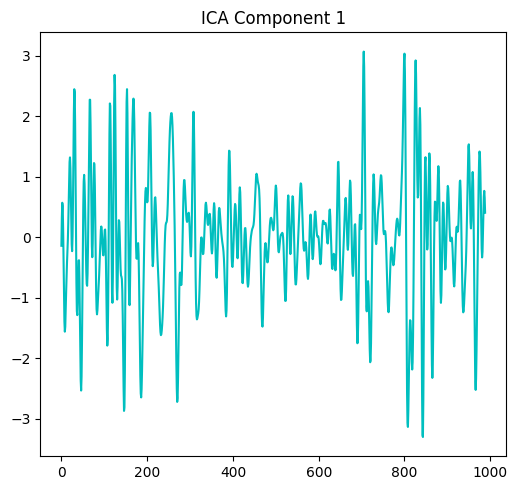

In [41]:
from sklearn.decomposition import FastICA

# X = df_normalized_ratios.values
# X = np.array(list(color_channel_ratios.values()))
X = df1['forehead'].values.reshape(-1, 1)

# Initialize and apply ICA
ica = FastICA(n_components=3, random_state=0)
S_ = ica.fit_transform(X) 
A_ = ica.mixing_ 

# Plot the independent components to identify the one most representative of the heart pulse
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, (component, color) in enumerate(zip(S_.T, ['c', 'm', 'y']), start=1):
    plt.subplot(1, 3, i)
    plt.plot(component, color=color)
    plt.title(f'ICA Component {i}')
plt.tight_layout()
plt.show()


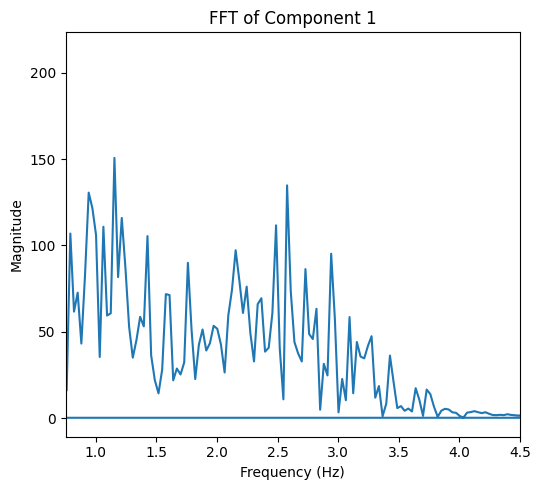

In [42]:
from scipy.fft import fft, fftfreq

fs = 30 
import numpy as np

# Compute the FFT and corresponding frequencies for each component again
fft_components = [fft(component) for component in S_.T]
freqs = fftfreq(X.shape[0], 1/fs)

# Plot the magnitude of the FFT for each component within the heart rate range (0.75 Hz to 4.5 Hz)
plt.figure(figsize=(15, 5))
for i, fft_component in enumerate(fft_components, start=1):
    plt.subplot(1, 3, i)
    plt.plot(freqs, np.abs(fft_component))
    plt.xlim(0.75, 4.5)  # Limit x-axis to target heart rate range
    plt.title(f'FFT of Component {i}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()


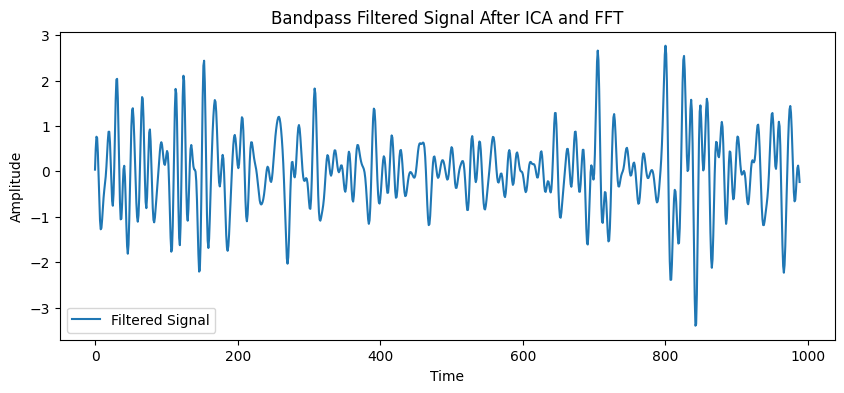

In [43]:
from scipy.signal import butter, filtfilt

# Function to design a bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply a bandpass filter to a signal
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

most_representative_component = S_[:, 0]  # Second ICA component selected

# Define heart rate range in Hz (45 bpm to 270 bpm)
lowcut = 45 / 60.0
highcut = 270 / 60.0

# Apply bandpass filter to the most representative component
filtered_signal = butter_bandpass_filter(most_representative_component, lowcut, highcut, fs, order=2)

# Plot the filtered signal
plt.figure(figsize=(10, 4))
plt.plot(filtered_signal, label='Filtered Signal')
plt.title('Bandpass Filtered Signal After ICA and FFT')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


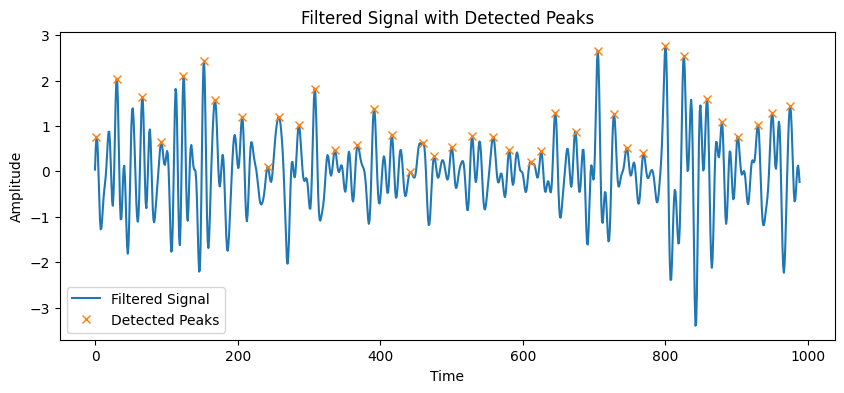

70.29804727646453

In [44]:
from scipy.signal import find_peaks

# Detect peaks in the filtered signal
peaks, _ = find_peaks(filtered_signal, distance=fs*0.5) 

# Calculate IBIs (Interbeat Intervals) in seconds
ibis = np.diff(peaks) / fs

# Calculate the average heart rate
if ibis.size > 0:
    avg_ibi = np.mean(ibis)
    heart_rate = 60 / avg_ibi  # Convert IBIs to heart rate in beats per minute (bpm)
else:
    heart_rate = 0  # No peaks detected, indicating no heart rate could be calculated

# Plot the filtered signal with detected peaks
plt.figure(figsize=(10, 4))
plt.plot(filtered_signal, label='Filtered Signal')
plt.plot(peaks, filtered_signal[peaks], "x", label='Detected Peaks')
plt.title('Filtered Signal with Detected Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

heart_rate

In [45]:
# Convert IBIs to a DataFrame for export
ibi_df = pd.DataFrame(ibis, columns=['IBI'])

# Save the IBI time series to a CSV file
ibi_csv_path = 'ibi_time_series.csv'
ibi_df.to_csv(ibi_csv_path, index=False)

ibi_csv_path

'ibi_time_series.csv'

### Validation based on Supplied BVP data with original UBFC-Phys dataset 

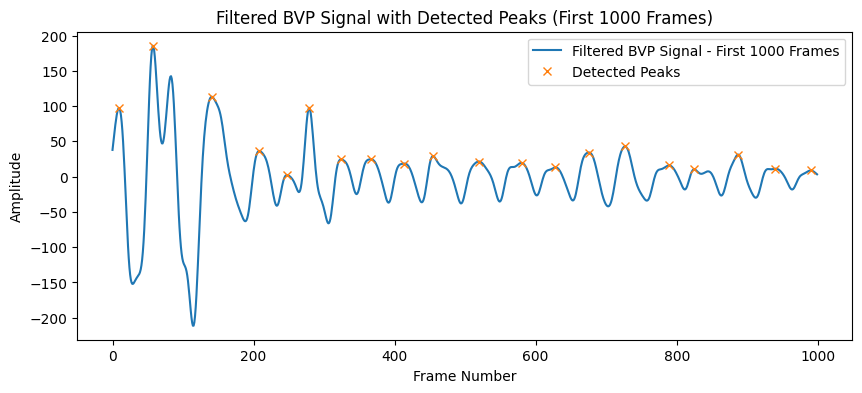

(74.37308868501529, array([0.75    , 1.3125  , 1.046875, 0.609375, 0.5     ]))

In [46]:
# bvp_path = 'dataset/s2/bvp_s2_T1.csv'
bvp_path = 'bvp_s1_T3.csv'

bvp_df = pd.read_csv(bvp_path)

fs_bvp = 64  # Hz, the sampling rate for BVP signals

# Redo the analysis using the first 1000 frames of the BVP data
filtered_bvp_signal_1000 = butter_bandpass_filter(bvp_df.values.flatten()[:1000], 0.5, 3.5, fs_bvp, order=2)

# Detect peaks in the filtered BVP signal limited to first 1000 frames
peaks_bvp_1000, _ = find_peaks(filtered_bvp_signal_1000, distance=fs_bvp*0.5)

# Calculate IBIs from BVP signal
ibis_bvp_1000 = np.diff(peaks_bvp_1000) / fs_bvp

# Calculate average heart rate from IBIs
if ibis_bvp_1000.size > 0:
    avg_heart_rate_bvp_1000 = 60 / np.mean(ibis_bvp_1000)
else:
    avg_heart_rate_bvp_1000 = 0  # No IBIs

# Plot the filtered BVP signal with detected peaks for visualization
plt.figure(figsize=(10, 4))
plt.plot(filtered_bvp_signal_1000, label='Filtered BVP Signal - First 1000 Frames')
plt.plot(peaks_bvp_1000, filtered_bvp_signal_1000[peaks_bvp_1000], "x", label='Detected Peaks')
plt.title('Filtered BVP Signal with Detected Peaks (First 1000 Frames)')
plt.xlabel('Frame Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

avg_heart_rate_bvp_1000, ibis_bvp_1000[:5]  # Show the average heart rate and the first few IBIs for reference


In [47]:
import numpy as np
from scipy.signal import butter, filtfilt, detrend, find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import zscore

class HeartMetricsCalculator:
    def __init__(self, fs=30):
        self.fs = fs

    @staticmethod
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    @staticmethod
    def compute_IBI(peaks, fs):
        return np.diff(peaks) / fs

    @staticmethod
    def calculate_baevsky_stress_index(ibi):
        hist, bin_edges = np.histogram(ibi, bins=np.arange(0, max(ibi) + 0.05, 0.05))
        amplitude = np.max(hist) / len(ibi)
        sdnn = np.std(ibi)
        bsi = amplitude / (2 * 3.92 * sdnn) * 10
        return bsi

    def calculate_hrv_metrics(self, ibi):
        sdnn = np.std(ibi)
        rmssd = np.sqrt(np.mean(np.square(np.diff(ibi))))
        bsi = self.calculate_baevsky_stress_index(ibi)
        frequencies = fftfreq(len(ibi), d=np.mean(ibi) if len(ibi) > 0 else 0)
        power_spectrum = np.abs(fft(ibi))**2
        lf_band = (0.04, 0.15)
        hf_band = (0.15, 0.4)
        lf_power = np.sum(power_spectrum[(frequencies >= lf_band[0]) & (frequencies < lf_band[1])])
        hf_power = np.sum(power_spectrum[(frequencies >= hf_band[0]) & (frequencies < hf_band[1])])
        lf_hf_ratio = lf_power / hf_power if hf_power != 0 else np.nan
        return sdnn, rmssd, bsi, lf_hf_ratio


### HRV Metrics Comparison

In [48]:
# Initialize calculators for both datasets
fs_current = 30
calculator_current = HeartMetricsCalculator(fs=fs_current)
fs_bvp = 64
calculator_bvp = HeartMetricsCalculator(fs=fs_bvp)

# Calculate HRV metrics for both datasets
sdnn_current, rmssd_current, bsi_current, lf_hf_ratio_current = calculator_current.calculate_hrv_metrics(ibis)
sdnn_bvp, rmssd_bvp, bsi_bvp, lf_hf_ratio_bvp = calculator_bvp.calculate_hrv_metrics(ibis_bvp_1000)

# Calculate average heart rates from IBIs
avg_heart_rate_current = 60 / np.mean(ibis) if ibis.size > 0 else 0
avg_heart_rate_bvp_1000 = 60 / np.mean(ibis_bvp_1000) if ibis_bvp_1000.size > 0 else 0

# Display the HRV metrics and heart rates for both methods
hrv_metrics_comparison = pd.DataFrame({
    'Metric': ['Heart Rate', 'SDNN', 'RMSSD', 'BSI', 'LF/HF Ratio'],
    'Current Calculation': [avg_heart_rate_current, sdnn_current, rmssd_current, bsi_current, lf_hf_ratio_current],
    'BVP Dataset Calculation': [avg_heart_rate_bvp_1000, sdnn_bvp, rmssd_bvp, bsi_bvp, lf_hf_ratio_bvp]
})

print(hrv_metrics_comparison)

        Metric  Current Calculation  BVP Dataset Calculation
0   Heart Rate            70.298047                74.373089
1         SDNN             0.194897                 0.191179
2        RMSSD             0.283161                 0.259268
3          BSI             1.033349                 1.404592
4  LF/HF Ratio             0.119632                 0.514026


In [49]:
from datetime import datetime

current_metrics = hrv_metrics_comparison[['Metric', 'Current Calculation']].copy()
current_metrics['Timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
# print(current_metrics)
current_metrics.rename(columns={'Current Calculation': 'Calculation'}, inplace=True)
# Generate a new filename each time
filename = f"hrv_metrics_{np.random.randint(1000)}.csv"


# Save the DataFrame as CSV
current_metrics.to_csv(filename, index=False)
current_metrics

,Metric,Calculation,Timestamp
0,Heart Rate,70.298047,2024-06-10 21:09:05
1,SDNN,0.194897,2024-06-10 21:09:05
2,RMSSD,0.283161,2024-06-10 21:09:05
3,BSI,1.033349,2024-06-10 21:09:05
4,LF/HF Ratio,0.119632,2024-06-10 21:09:05


In [50]:
current_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Metric       5 non-null      object 
 1   Calculation  5 non-null      float64
 2   Timestamp    5 non-null      object 
dtypes: float64(1), object(2)
memory usage: 248.0+ bytes


# Statistial analysis

In [51]:
from scipy.stats import ttest_rel, wilcoxon

# Perform paired t-test and Wilcoxon signed-rank test on the metrics
# Wilcoxon test is used as a non-parametric alternative to the paired t-test

# Convert metrics to numpy arrays for statistical testing
previous_metrics = np.array([sdnn_current, rmssd_current, bsi_current, lf_hf_ratio_current])
bvp_metrics = np.array([sdnn_bvp, rmssd_bvp, bsi_bvp, lf_hf_ratio_bvp])

# Paired t-test
t_test_stat, t_test_p = ttest_rel(previous_metrics, bvp_metrics)

# Wilcoxon signed-rank test
wilcoxon_stat, wilcoxon_p = wilcoxon(previous_metrics, bvp_metrics)

t_test_stat, t_test_p, wilcoxon_stat, wilcoxon_p


(-1.6090663500910214, 0.2059745275819467, 3.0, 0.625)

In [242]:
# These statistical tests suggest that there are no statistically significant differences between the two sets of HRV metrics at the conventional alpha level of 0.05. The p-values indicate that the observed differences in HRV metrics could likely be due to random variation rather than systematic differences between the methodologies used to calculate them.

In [52]:
# First, let's load the provided data into a DataFrame to understand its structure
import pandas as pd

# Load the data from the uploaded CSV file
df = pd.read_csv('hrv_metrics_635.csv')

# Display the first few rows of the dataframe to understand its structure
df.head()


,Metric,Calculation,Timestamp
0,Heart Rate,70.298047,2024-06-10 21:09:05
1,SDNN,0.194897,2024-06-10 21:09:05
2,RMSSD,0.283161,2024-06-10 21:09:05
3,BSI,1.033349,2024-06-10 21:09:05
4,LF/HF Ratio,0.119632,2024-06-10 21:09:05


In [54]:
df = hrv_metrics_comparison.copy()

In [ ]:
hrv_metrics_comparison.to_csv('hrv_metrics_comparison_t3.csv')

In [55]:
df

,Metric,Current Calculation,BVP Dataset Calculation
0,Heart Rate,70.298047,74.373089
1,SDNN,0.194897,0.191179
2,RMSSD,0.283161,0.259268
3,BSI,1.033349,1.404592
4,LF/HF Ratio,0.119632,0.514026


In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize dictionaries to hold the calculation results for each metric
mae_results = {}
rmse_results = {}
correlation_results = {}

# Iterate over each unique metric in the dataset
for metric in df['Metric'].unique():
    # Filter the dataframe for the current metric
    metric_df = df[df['Metric'] == metric]
    
    # Calculate MAE
    mae = mean_absolute_error(metric_df['Current Calculation'], metric_df['BVP Dataset Calculation'])
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(metric_df['Current Calculation'], metric_df['BVP Dataset Calculation']))
    
    # Calculate correlation coefficient
    correlation = np.corrcoef(metric_df['Current Calculation'], metric_df['BVP Dataset Calculation'])[0, 1]
    
    # Store the results in the dictionaries
    mae_results[metric] = mae
    rmse_results[metric] = rmse
    correlation_results[metric] = correlation

# Convert the results to DataFrames for better visualization
mae_df = pd.DataFrame(list(mae_results.items()), columns=['Metric', 'MAE'])
rmse_df = pd.DataFrame(list(rmse_results.items()), columns=['Metric', 'RMSE'])
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Metric', 'Correlation'])

(mae_df, rmse_df, correlation_df)


(        Metric       MAE
 0   Heart Rate  4.075041
 1         SDNN  0.003718
 2        RMSSD  0.023893
 3          BSI  0.371243
 4  LF/HF Ratio  0.394394,
         Metric      RMSE
 0   Heart Rate  4.075041
 1         SDNN  0.003718
 2        RMSSD  0.023893
 3          BSI  0.371243
 4  LF/HF Ratio  0.394394,
         Metric  Correlation
 0   Heart Rate          NaN
 1         SDNN          NaN
 2        RMSSD          NaN
 3          BSI          NaN
 4  LF/HF Ratio          NaN)

In [57]:
# Calculate the relative error between the current calculation and the BVP dataset calculation
df['Relative Error'] = abs(df['Current Calculation'] - df['BVP Dataset Calculation']) / df['BVP Dataset Calculation']
df['Accuracy'] = 1 - df['Relative Error']
accuracy_by_metric = df.groupby('Metric')['Accuracy'].mean().reset_index()
print(accuracy_by_metric)

        Metric  Accuracy
0          BSI  0.735693
1   Heart Rate  0.945208
2  LF/HF Ratio  0.232735
3        RMSSD  0.907845
4         SDNN  0.980553


In [58]:
df.groupby('Metric')['Accuracy'].mean().reset_index()['Accuracy'].to_csv('Accuracy.csv')

In [65]:
df.groupby('Metric')['Accuracy'].mean().reset_index()['Accuracy']

0    0.735693
1    0.945208
2    0.232735
3    0.907845
4    0.980553
Name: Accuracy, dtype: float64